Loaded pretrained weights for efficientnet-b3


C:\Users\JosephQ\AppData\Local\Temp\ipykernel_23440\2533862135.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


FileUpload(value=(), accept='image/*', description='Upload')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.50395256..1.0].


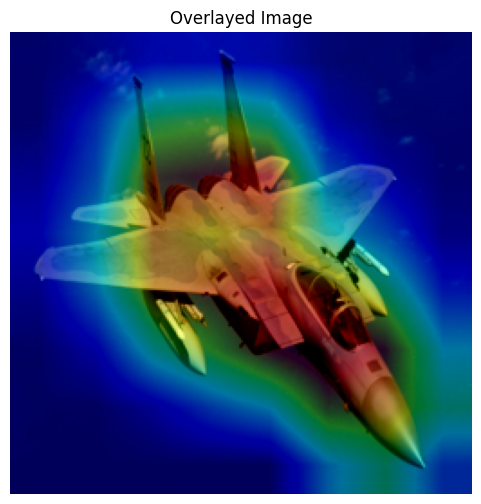

The predicted class is: F-15


In [32]:
import torch
from torchvision import transforms
from PIL import Image
from efficientnet_pytorch import EfficientNet
import numpy as np
import cv2
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
import gradio as gr
import os
import ipywidgets as widgets
from IPython.display import display

import torch.nn as nn 
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Load the model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b3')
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1000, 74)
        self.bn = nn.BatchNorm1d(1000)

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Load the trained model weights
model = NeuralNet()
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Define the class names
class_names = ["A-10", "A-400M", "AG-600", "AH-64", "AV-8B", "An-124", "An-22", "An-225", "An-72", "B-1", "B-2", "B-21", "B-52", "Be-200", "C-130", "C-17", "C-2", "C-390", "C-5", "CH-47", "CL-415", "E-2", "E-7", "EF-2000", "F-117", "F-14", "F-15", "F-16", "F-22", "F-35", "F-4", "F/A-18", "H-6", "J-10", "J-20", "JAS-39", "JF-17", "JH-7", "KC-135", "KF-21", "KJ-600", "Ka-27", "Ka-52", "MQ-9", "Mi-24", "Mi-26", "Mi-28", "Mig-29", "Mig-31", "Mirage2000", "P-3", "RQ-4", "Rafale", "SR-71", "Su-24", "Su-25", "Su-34", "Su-57", "TB-001", "TB-2", "Tornado", "Tu-160", "Tu-22M", "Tu-95", "U-2", "UH-60", "US-2", "V-22", "Vulcan", "WZ-7", "XB-70", "Y-20", "YF-23", "Z-19"]

# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to generate Grad-CAM heatmap
def generate_heatmap(image_path, model, transform, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    # Initialize Grad-CAM
    gradcam = GradCAM(model, model.efficientnet._blocks[-1])

    # Generate CAM mask
    mask, _ = gradcam(input_tensor)

    # Visualize the CAM mask
    heatmap, result = visualize_cam(mask, input_tensor)

    # Convert the result to a numpy array
    result = result.permute(1, 2, 0).numpy()

    # Display the result
    plt.figure(figsize=(6, 6))
    plt.imshow(result)
    plt.title('Overlayed Image')
    plt.axis('off')
    plt.show()

# Example usage

def classify_image(image_path, model, transform, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    # Perform the forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
    
    # Get the predicted class
    _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]

    return predicted_class

# Example usage

# Function to handle file upload and classification
def on_upload_change(change):
    # Get the uploaded file
    uploaded_file = change['new']
    if uploaded_file:
        # Get the file content
        content = uploaded_file[0]['content']
        # Save the file to a temporary location
        temp_image_path = os.path.join('', uploaded_file[0]['name'])
        with open(temp_image_path, 'wb') as f:
            f.write(content)
        
        # Generate heatmap
        generate_heatmap(temp_image_path, model, transform, class_names)
        
        # Classify the image
        predicted_class = classify_image(temp_image_path, model, transform, class_names)
        print(f'The predicted class is: {predicted_class}')

# Create a file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
upload_widget.observe(on_upload_change, names='value')

# Display the widget
display(upload_widget)